In [14]:
import pandas as pd
import numpy as np

Data: https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data

In [16]:
data_path = 'kkbox_data/'
train = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv(data_path + 'test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv(data_path + 'songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv(data_path + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')

source_system_tab: 'explore', 'my library', 'search', 'discover', nan, 'radio','listen with', 'notification'
source_screen_name: 'Explore', 'Local playlist more', nan, 'My library',
                    'Online playlist more', 'Album more', 'Discover Feature',
                    'Unknown', 'Discover Chart', 'Radio', 'Artist more', 'Search',
                    'Others profile more', 'Search Trends', 'Discover Genre',
                    'My library_Search', 'Search Home', 'Discover New'
source_type: 'online-playlist', 'local-playlist', 'local-library',
             'top-hits-for-artist', 'album', nan, 'song-based-playlist',
             'radio', 'song', 'listen-with', 'artist'

In [17]:
train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

In [19]:
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')

test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')

In [21]:
train['genre_ids'].dtype

CategoricalDtype(categories=['1007', '1011', '1011|2189|367', '1011|691', '1019', '1026',
                  '1033', '1040', '1040|1155', '1047',
                  ...
                  '465|1609|1259', '465|2122|2189|367', '465|2122|691',
                  '465|388|2189|367', '1138|2022', '1259|2107', '1609|437',
                  '1969|940|2100', '786|958|2022', '873|1609'],
                 ordered=False)

In [25]:
train['genre_ids'] = train['genre_ids'].replace(np.nan, 'no_genre_id', regex=True)
train['genre_ids']

0                  359
1                 1259
2                 1259
3                 1019
4                 1011
5                 1259
6                  465
7                 1011
8                 2022
9                  465
10                 465
11                 465
12                 465
13                 458
14             465|458
15                 465
16                 465
17                 458
18                 465
19                 465
20                 458
21                 465
22                 465
23                2022
24                2022
25                2022
26                 465
27                 465
28                 465
29         no_genre_id
              ...     
7377388            451
7377389            458
7377390            458
7377391            458
7377392            465
7377393            465
7377394            465
7377395            458
7377396            465
7377397            465
7377398            465
7377399            465
7377400    

New parameters:
1. genre_id_count: the amount of genre_id
2. lyricist_count: how many lyricists
3. composer_count: how many composers
4. is_featured: is "feat"
5. artist_count: how many artists
6. song_lang_boolean: 17 or 45
7. smaller_song: whether it is smaller than mean
8. count_song_played: how many times it have been played
9. count_artist_played: how many times his songs have been played

In [28]:
def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1

train['genre_ids'] = train['genre_ids'].replace(np.nan, 'no_genre_id', regex=True)
test['genre_ids'] = test['genre_ids'].replace(np.nan, 'no_genre_id', regex=True)

train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)

def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train['lyricist'] = train['lyricist'].replace(np.nan, 'no_lyricist', regex=True)
test['lyricist'] = test['lyricist'].replace(np.nan, 'no_lyricist', regex=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)

def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'] = train['composer'].replace(np.nan, 'no_composer', regex=True)
test['composer'] = test['composer'].replace(np.nan, 'no_composer', regex=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)

def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

train['artist_name'] = train['artist_name'].replace(np.nan, 'no_artist', regex=True)
test['artist_name'] = test['artist_name'].replace(np.nan, 'no_artist', regex=True)
train['is_featured'] = train['artist_name'].apply(is_featured).astype(np.int8)
test['is_featured'] = test['artist_name'].apply(is_featured).astype(np.int8)

def artist_count(x):
    if x == 'no_artist':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&')

train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

# if artist is same as composer
train['artist_composer'] = (train['artist_name'] == train['composer']).astype(np.int8)
test['artist_composer'] = (test['artist_name'] == test['composer']).astype(np.int8)


# if artist, lyricist and composer are all three same
train['artist_composer_lyricist'] = ((train['artist_name'] == train['composer']) & (train['artist_name'] == train['lyricist']) & (train['composer'] == train['lyricist'])).astype(np.int8)
test['artist_composer_lyricist'] = ((test['artist_name'] == test['composer']) & (test['artist_name'] == test['lyricist']) & (test['composer'] == test['lyricist'])).astype(np.int8)

# is song language 17 or 45. 
def song_lang_boolean(x):
    if '17.0' in str(x) or '45.0' in str(x):
        return 1
    return 0

train['song_lang_boolean'] = train['language'].apply(song_lang_boolean).astype(np.int8)
test['song_lang_boolean'] = test['language'].apply(song_lang_boolean).astype(np.int8)


_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)
test['smaller_song'] = test['song_length'].apply(smaller_song).astype(np.int8)

# number of times a song has been played before
_dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
_dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def count_song_played(x):
    try:
        return _dict_count_song_played_train[x]
    except KeyError:
        try:
            return _dict_count_song_played_test[x]
        except KeyError:
            return 0
    

train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)
test['count_song_played'] = test['song_id'].apply(count_song_played).astype(np.int64)

# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name'].value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test['artist_name'].value_counts().iteritems()}
def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)


Parameters

In [40]:
train.iloc[0]

msno                        FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=
song_id                     BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=
source_system_tab                                                explore
source_screen_name                                               Explore
source_type                                              online-playlist
target                                                                 1
song_length                                                       206471
genre_ids                                                            359
artist_name                                                     Bastille
composer                                            Dan Smith| Mark Crew
lyricist                                                     no_lyricist
language                                                            52.0
city                                                                   1
bd                                                 

In [47]:
train1 = train.iloc[:, 11:]
test1 = test.iloc[:, 11:]
train1.drop(columns=['gender'])
test1.drop(columns=['gender'])

,language,city,bd,registered_via,expiration_date,membership_days,registration_year,registration_month,registration_date,expiration_year,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
0,3.0,1,0,7,18,577,2016,2,19,2017,...,0,1,0,0,0,0,0,1,694,13654
1,3.0,1,0,7,18,577,2016,2,19,2017,...,2,1,0,0,0,0,0,0,6090,115325
2,17.0,1,0,4,24,7,2016,11,17,2016,...,1,1,0,0,0,0,1,0,5,989
3,52.0,3,30,9,30,3567,2007,7,25,2017,...,0,4,0,0,0,0,0,0,31,698
4,-1.0,3,30,9,30,3567,2007,7,25,2017,...,0,1,0,0,0,0,0,1,5,180
5,31.0,3,30,9,30,3567,2007,7,25,2017,...,0,0,0,0,0,0,0,1,81,3733
6,31.0,3,30,9,30,3567,2007,7,25,2017,...,2,1,0,0,0,0,0,1,90,4425
7,3.0,3,30,9,30,3567,2007,7,25,2017,...,1,1,0,0,0,0,0,0,1053,4204
8,3.0,3,30,9,30,3567,2007,7,25,2017,...,1,1,0,0,0,0,0,0,848,1485
9,31.0,1,0,7,18,639,2015,12,19,2017,...,0,0,0,0,0,0,0,1,2381,61927


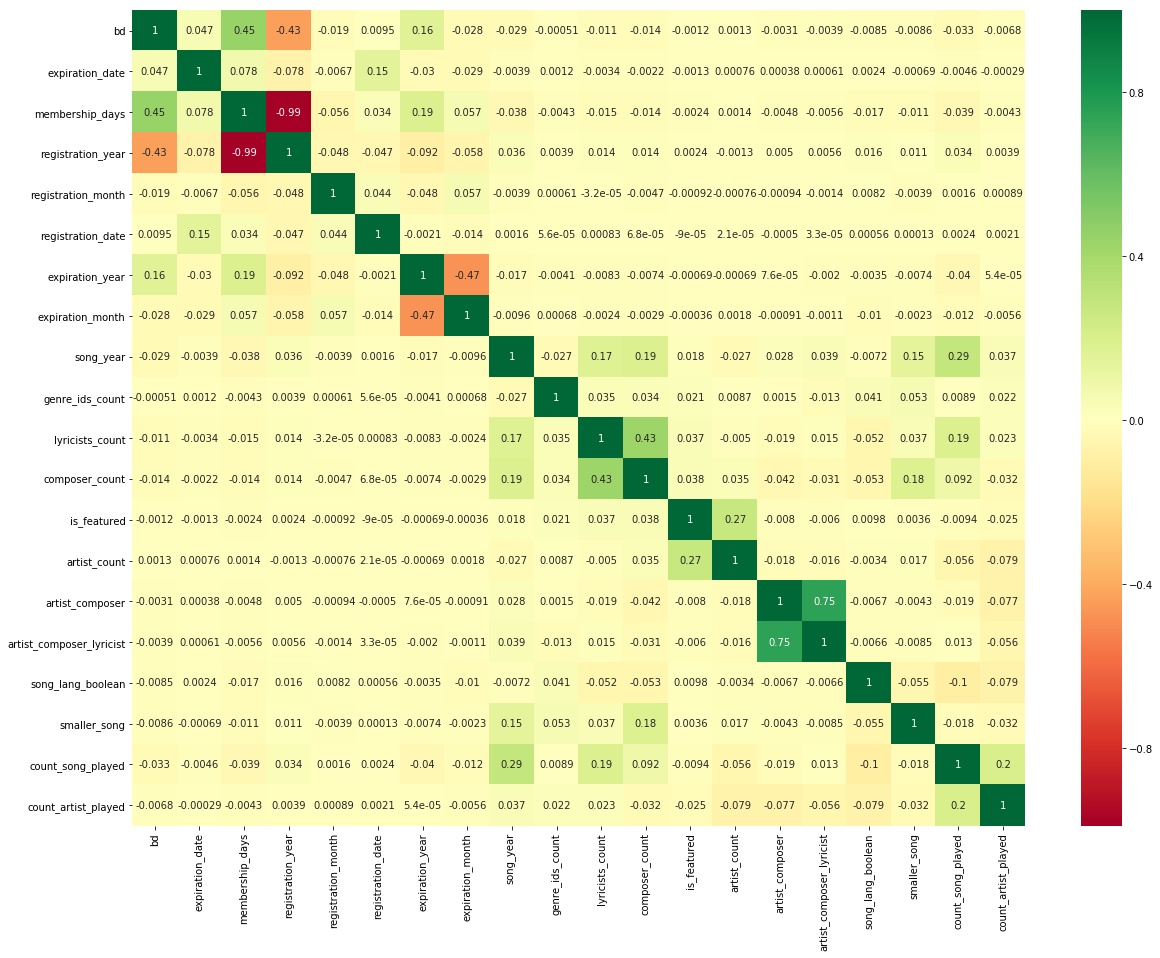

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,15)) 

correlation = train1.corr()
sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")

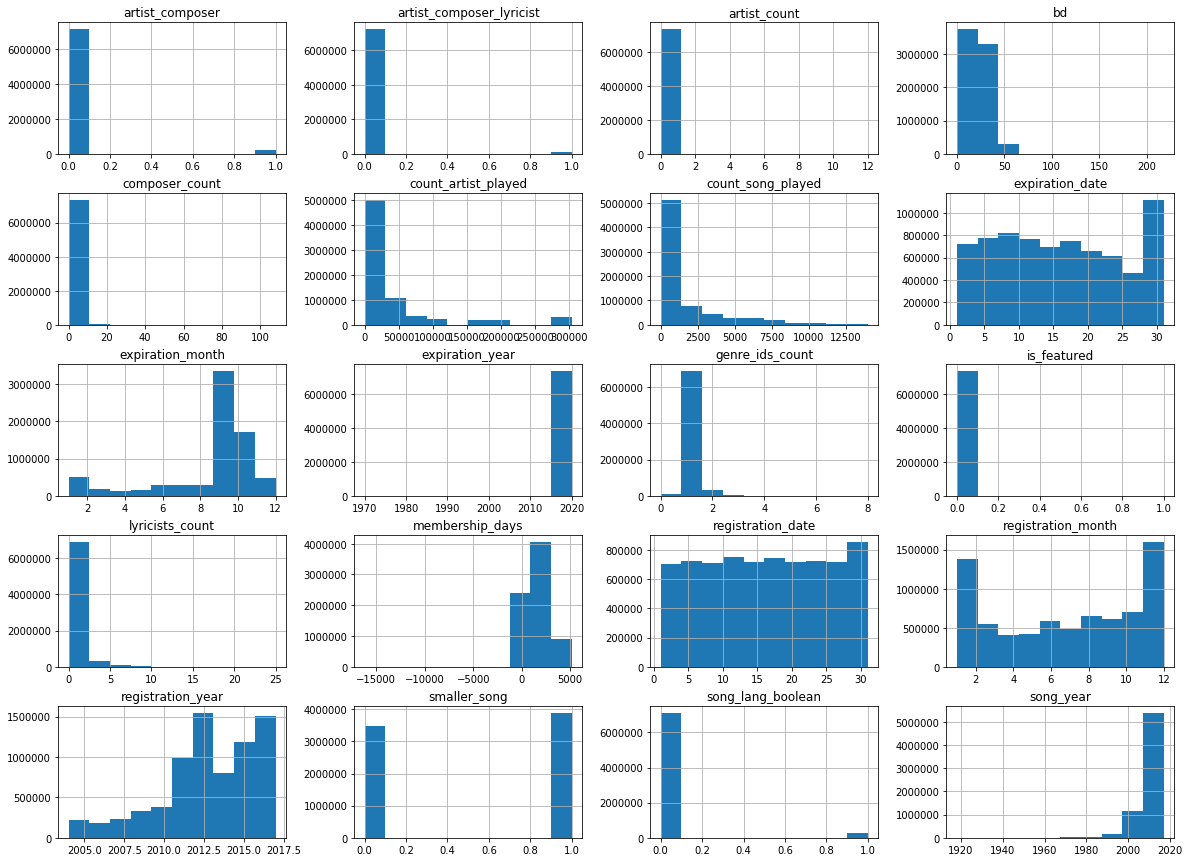

In [52]:
hist = train1.hist(figsize=(20,15))

In [ ]:
# TO Do: inplement the deep learning method